# Detecção de SPAM com Modelo LSTM e Vetorização GloVe
Este notebook apresenta uma pipeline para a detecção de mensagens SPAM utilizando um modelo de rede neural LSTM com vetorização GloVe. Além disso, comparamos o desempenho com uma abordagem alternativa utilizando TF-IDF e uma rede neural simples.

## 1. Importação das Bibliotecas Necessárias
Primeiramente, importamos todas as bibliotecas necessárias para a manipulação de dados, visualização, processamento de linguagem natural (PLN) e construção de modelos de aprendizado de máquina.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

## 2. Download dos Recursos do NLTK
Baixamos os recursos necessários do NLTK, como stopwords, tokenizador e lematizador, que serão utilizados no pré-processamento dos dados.


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 3. Dataset
Carregamos o dataset de SPAM disponível no Kaggle. Após a leitura, renomeamos as colunas para consistência e mantemos apenas as colunas relevantes: `label` e `text`.


In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.rename(columns={'Category': 'label', 'Message': 'text'})
df = df[['label', 'text']]
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 4. Análise Exploratória dos Dados (EDA)
Realizamos uma análise exploratória para entender a distribuição das classes e características das mensagens.

### 4.1. Distribuição das Classes
Observamos que há um desbalanceamento nas classes, com uma quantidade significativamente maior de mensagens 'ham' em comparação com 'spam'.

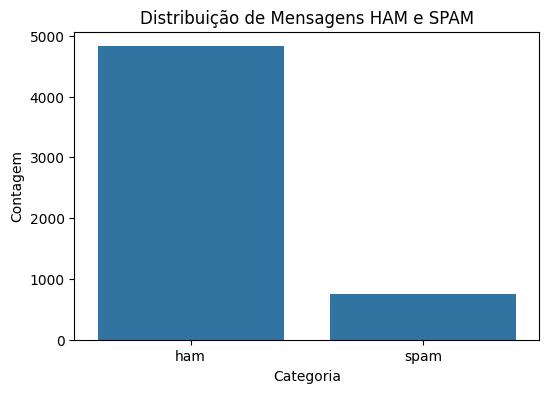

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Distribuição de Mensagens HAM e SPAM')
plt.xlabel('Categoria')
plt.ylabel('Contagem')
plt.show()

### 4.2. Distribuição do Número de Palavras por Mensagem
Adicionamos uma coluna que conta o número de palavras em cada mensagem e visualizamos a distribuição.

Percebemos que as mensagens 'ham' tendem a ter mais palavras do que as mensagens 'spam', indicando que o comprimento da mensagem pode ser uma característica relevante para a classificação.

In [5]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

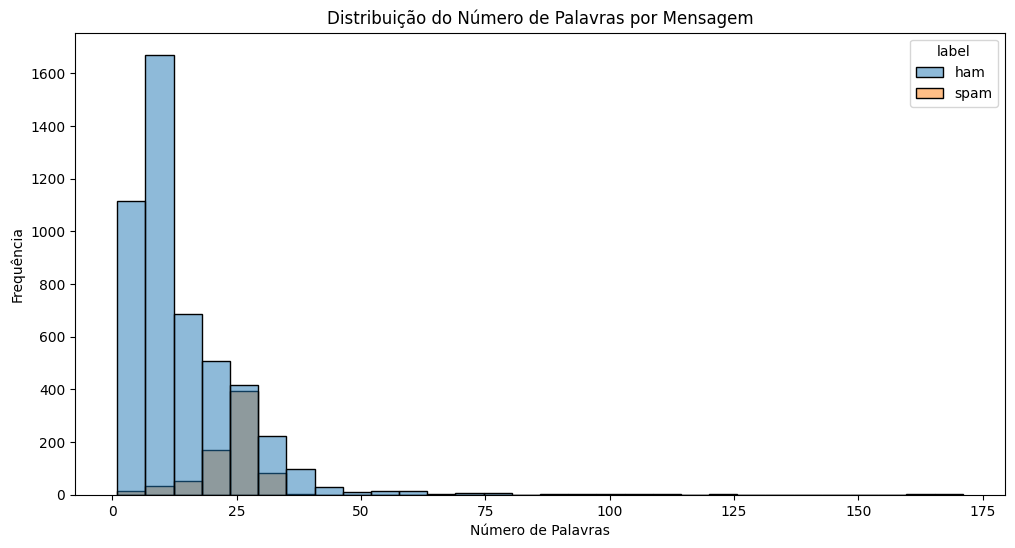

In [6]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='word_count', hue='label', bins=30, color='skyblue')
plt.title('Distribuição do Número de Palavras por Mensagem')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.show()

### 4.3. Nuvens de Palavras
Criamos nuvens de palavras para as mensagens `spam` e `ham` para visualizar as palavras mais frequentes em cada categoria.


#### 4.3.1. Nuvem de Palavras para Mensagens SPAM
Na nuvem de palavras das mensagens 'spam', notamos a prevalência de termos relacionados a ofertas, prêmios e "urgência", como 'free', 'call', 'now', sugerindo que mensagens de spam frequentemente utilizam essas palavras para atrair atenção.

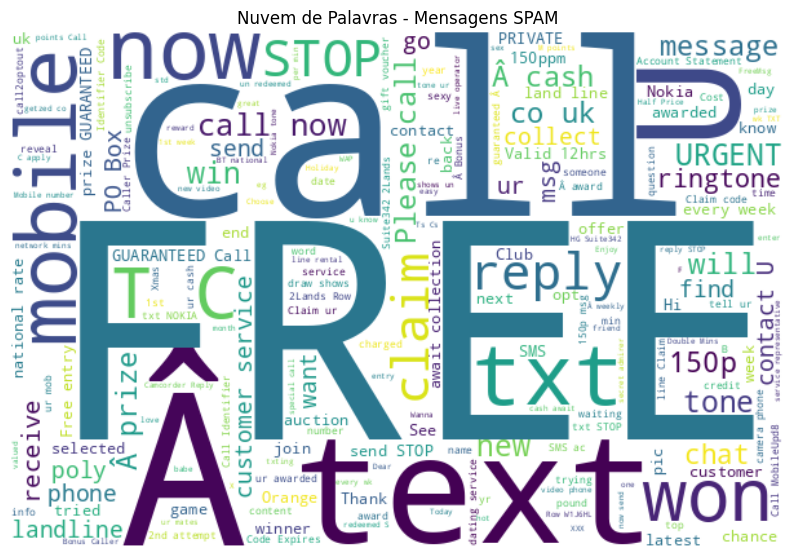

In [7]:
spam_words = ' '.join(list(df[df['label']=='spam']['text']))
spam_wordcloud = WordCloud(width=600, height=400, background_color='white').generate(spam_words)
plt.figure(figsize=(10,8))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Mensagens SPAM')
plt.show()

#### 4.3.2. Nuvem de Palavras para Mensagens HAM
A nuvem de palavras das mensagens 'ham' mostra termos mais relacionados ao cotidiano e comunicações pessoais, como 'will', 'go', 'got', 'ok' indicando que essas mensagens são geralmente conversas normais.

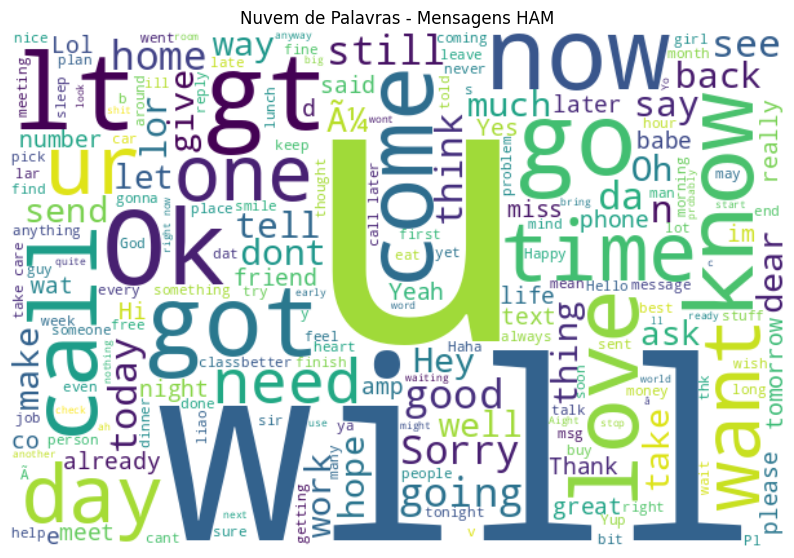

In [8]:
ham_words = ' '.join(list(df[df['label']=='ham']['text']))
ham_wordcloud = WordCloud(width=600, height=400, background_color='white').generate(ham_words)
plt.figure(figsize=(10,8))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Mensagens HAM')
plt.show()

## 5. Pré-Processamento dos Dados
Aplicamos uma pipeline de processamento para limpar e preparar os dados para a vetorização.


### 5.1. Função de Pré-Processamento
A função `preprocess_text` realiza as seguintes etapas:
- Converte o texto para minúsculas.
- Remove pontuação.
- Tokeniza o texto.
- Remove stopwords.
- Realiza a lematização.
- Junta as palavras processadas em uma única string.


In [9]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    return text

### 5.2. Aplicação do Pré-Processamento
Aplicamos a função de pré-processamento a todas as mensagens do dataset.


In [10]:
df['clean_text'] = df['text'].apply(preprocess_text)
print("\nDataframe após pré-processamento:")
df[['label', 'clean_text']].head()


Dataframe após pré-processamento:


,label,clean_text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah dont think go usf life around though


## 6. Vetorização com GloVe
Transformamos os textos pré-processados em representações numéricas utilizando vetorização baseada nos embeddings GloVe.



### 6.1. Definição dos Parâmetros
Estabelecemos os parâmetros para a vetorização e o modelo.

In [11]:
MAX_NUM_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

### 6.2. Tokenização e Sequenciamento
Tokenizamos os textos e transformamos as entradas em sequências.

In [12]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

### 6.3. Codificação das Labels
Convertendo as labels `ham` e `spam` para valores numéricos.


In [13]:
le = LabelEncoder()
y = le.fit_transform(df['label'])

### 6.4. Carregamento dos Embeddings GloVe
Carregamos os embeddings pré-treinados GloVe. É necessário fazer o download do arquivo 'glove.6B.100d.txt' disponível em [Embeddings GloVe](http://nlp.uoregon.edu/download/embeddings/) e colocá-lo no diretório de trabalho

In [14]:
print("\nCarregando embeddings GloVe...")
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("Embeddings GloVe carregados com sucesso.")


Carregando embeddings GloVe...
Embeddings GloVe carregados com sucesso.


### 6.5. Criação da Matriz de Embeddings
Construímos uma matriz de embeddings onde cada linha corresponde a uma palavra no vocabulário, representada pelo vetor de embeddings correspondente.

In [15]:
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Matriz de Vetores abaixo

In [16]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.031087    0.22155     0.44494    ... -0.67097002  0.24698
  -0.62001002]
 [-0.57832998 -0.0036551   0.34658    ...  0.070204    0.44509
   0.24147999]
 ...
 [-0.39063999  0.95143002  0.21262001 ...  0.18808     0.25338
   1.05350006]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


### 6.6. Verificação do Formato dos Dados
Confirmamos as dimensões dos dados vetorizados e das labels.


In [ ]:
print('X:', X.shape)
print('y:', y.shape)

X: (5572, 100)
y: (5572,)


### 6.7. Divisão dos Dados em Treinamento e Teste
Dividimos os dados em conjuntos de treinamento e teste para avaliar o desempenho do modelo.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 7. Construção e Treinamento do Modelo LSTM
Desenvolvemos um modelo LSTM utilizando os embeddings GloVe para a detecção de SPAM.


### 7.1. Construção do Modelo
Configuramos a arquitetura do modelo, incluindo a camada de embedding, LSTM e camadas densas.

In [ ]:
model = Sequential()
model.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(16,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 7.2. Compilação do Modelo
Compilamos o modelo especificando a função de perda, otimizador e métricas de avaliação.


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 7.3. Treinamento do Modelo
Treinamos o modelo utilizando o subset de treino.

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8731 - loss: 0.4011 - val_accuracy: 0.9507 - val_loss: 0.1538
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9680 - loss: 0.1101 - val_accuracy: 0.9529 - val_loss: 0.1423
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9778 - loss: 0.0751 - val_accuracy: 0.9484 - val_loss: 0.1577
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9795 - loss: 0.0610 - val_accuracy: 0.9552 - val_loss: 0.1569
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9810 - loss: 0.0670 - val_accuracy: 0.9619 - val_loss: 0.1400


## 8. Avaliação do Modelo LSTM
Após o treinamento, avaliamos o desempenho do modelo utilizando o conjunto de teste.

### 8.1. Avaliação da Acurácia
Calculamos a acurácia do modelo no conjunto de teste.


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('\nAcurácia no conjunto de teste: {:.2f}%'.format(accuracy * 100))

35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9749 - loss: 0.0811

Acurácia no conjunto de teste: 97.31%


### 8.2. Matriz de Confusão
Visualizamos a matriz de confusão para entender melhor os tipos de erros cometidos pelo modelo.

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step


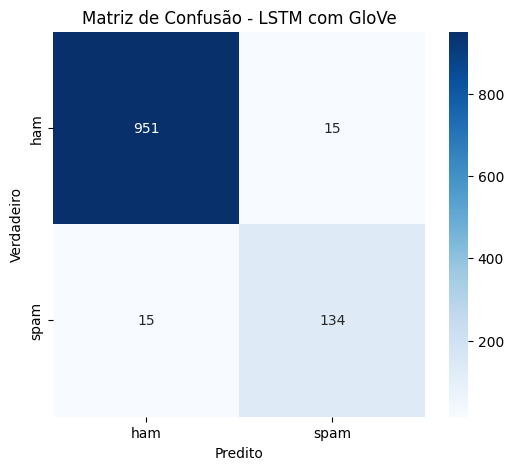

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - LSTM com GloVe')
plt.show()

### 8.3. Resultados para métricas

In [ ]:
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       966
        spam       0.90      0.90      0.90       149

    accuracy                           0.97      1115
   macro avg       0.94      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115



## 9. Abordagem Alternativa: Vetorização TF-IDF e Rede Neural Simples
Implementamos uma abordagem alternativa utilizando a vetorização TF-IDF combinada com uma rede neural simples para comparação de desempenho.

*   List item
*   List item



### 9.1. Vetorização com TF-IDF
Utilizamos o `TfidfVectorizer` para transformar os textos em representações numéricas baseadas na frequência inversa de termos.


In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_text']).toarray()

### 9.2. Divisão dos Dados
Dividimos os dados vetorizados em conjuntos de treinamento e teste.


In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

### 9.3. Construção e Treinamento da Rede Neural
Desenvolvemos e treinamos uma rede neural: com camadas densas para a detecção de SPAM.

In [ ]:
model_tfidf = Sequential()
model_tfidf.add(Dense(64, input_dim=X_train_tfidf.shape[1], activation='relu'))
model_tfidf.add(Dropout(0.5))
model_tfidf.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 9.4. Compilando o Modelo

In [ ]:
model_tfidf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 9.5 Treino

In [ ]:
history_tfidf = model_tfidf.fit(X_train_tfidf, y_train_tfidf, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8067 - loss: 0.6417 - val_accuracy: 0.8453 - val_loss: 0.4629
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8656 - loss: 0.3922 - val_accuracy: 0.8812 - val_loss: 0.2894
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9380 - loss: 0.2158 - val_accuracy: 0.9283 - val_loss: 0.1944
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9667 - loss: 0.1363 - val_accuracy: 0.9507 - val_loss: 0.1452
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9788 - loss: 0.0932 - val_accuracy: 0.9552 - val_loss: 0.1220


### 9.6. Avaliação do Modelo com TF-IDF
Avaliação do desempenho da rede neural no conjunto de teste.



In [ ]:
loss_tfidf, accuracy_tfidf = model_tfidf.evaluate(X_test_tfidf, y_test_tfidf)
print('\nAcurácia no conjunto de teste com TF-IDF: {:.2f}%'.format(accuracy_tfidf * 100))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9699 - loss: 0.0992

Acurácia no conjunto de teste com TF-IDF: 97.58%


### 9.7. Matriz de Confusão com TF-IDF
Visualizamos a matriz de confusão para a abordagem com TF-IDF.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


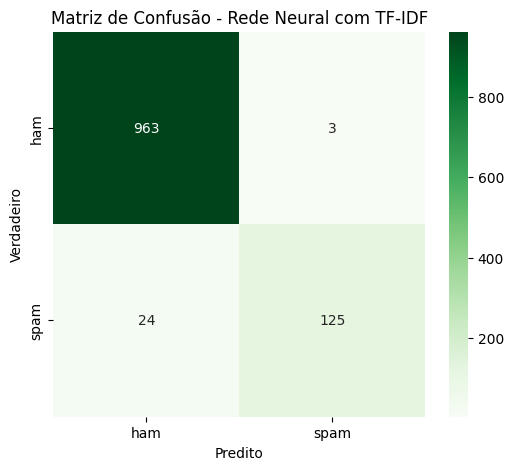

In [ ]:
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
y_pred_classes_tfidf = (y_pred_tfidf > 0.5).astype('int32')
cm_tfidf = confusion_matrix(y_test_tfidf, y_pred_classes_tfidf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Rede Neural com TF-IDF')
plt.show()

### 9.8. Relatório de Classificação com TF-IDF
Geramos um relatório detalhado para a abordagem com TF-IDF.


In [ ]:
print(classification_report(y_test_tfidf, y_pred_classes_tfidf, target_names=le.classes_))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.84      0.90       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.94      1115
weighted avg       0.98      0.98      0.97      1115



## 10. Comparação dos Resultados
Ao comparar os dois modelos, LSTM com vetorização GloVe e rede neural com TF-IDF, observamos que ambos apresentaram uma excelente performance, mas com diferenças importantes nas métricas de avaliação.

GloVe + LSTM: apresentou uma **acurácia geral de 97.31%**, com valores parecidos entre precisão e recall, tanto para as mensagens "ham" quanto para "spam". Na matriz de confusão, o LSTM cometeu **15 erros** ao classificar mensagens "ham" como "spam" e o mesmo número ao classificar mensagens "spam" como "ham".

Essa performance mostra que o modelo é particularmente bom ao identificar mensagens "ham" (não-spam), com uma taxa de falsos positivos e falsos negativos relativamente baixa. A **precisão e recall para spam** foram ligeiramente inferiores, indicando que há ainda espaço para melhorias na classificação de mensagens indesejadas.

Utilizando a rede neural com TF-IDF, os resultados em acurácia foram aproximados, atingindo métricas levemente mais altas.

Esse modelo cometeu menos erros ao classificar "ham" como "spam" (apenas 3 erros), mas teve mais dificuldade ao identificar mensagens "spam", cometendo 24 erros ao classificá-las como "ham".

Os resultados sugerem que a rede neural com TF-IDF tem um bom resultado ao identificar corretamente as mensagens normais (ham), mas pode deixar passar muitas mensagens de spam como se fossem ham. Isso é refletido na queda no recall para spam, o que significa que o modelo não detecta toda essa classe corretamente, sendo mais "conservador" ao classificar.

 O tamanho reduzido do dataset pode ter limitado o potencial do LSTM, que normalmente requer grandes quantidades de dados. Além disso, os embeddings GloVe, pré-treinados em textos genéricos, podem não capturar nuances específicas de mensagens de spam.

In [ ]:
print('\n--- Comparação dos Resultados ---')
print('Acurácia com LSTM e GloVe: {:.2f}%'.format(accuracy * 100))
print('Acurácia com Rede Neural Simples e TF-IDF: {:.2f}%'.format(accuracy_tfidf * 100))

print("Métricas LSTM + Glove")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

print("Métricas Rede Neural Simples + TF-IDF")
print(classification_report(y_test_tfidf, y_pred_classes_tfidf, target_names=le.classes_))


--- Comparação dos Resultados ---
Acurácia com LSTM e GloVe: 97.31%
Acurácia com Rede Neural Simples e TF-IDF: 97.58%
Métricas LSTM + Glove
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       966
        spam       0.90      0.90      0.90       149

    accuracy                           0.97      1115
   macro avg       0.94      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Métricas Rede Neural Simples + TF-IDF
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.84      0.90       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.94      1115
weighted avg       0.98      0.98      0.97      1115



# Referências

- [Embeddings GloVe](https://nlp.stanford.edu/projects/glove/)
- [NLTK Documentation](https://www.nltk.org/)
- [TensorFlow Keras Documentation](https://www.tensorflow.org/api_docs/python/tf/keras)
- [Scikit-learn Documentation](https://scikit-learn.org/stable/)
- [Basics of Using Pre-trained GloVe Vectors in Python](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)
- [Simple Guide for LSTM and Glove Embeddings](https://www.kaggle.com/code/samarthsarin/simple-guide-for-lstm-and-glove-embeddings)
- [Embeddings GloVe - Files](http://nlp.uoregon.edu/download/embeddings/)
- [Spam Dataset - Kaggle](https://www.kaggle.com/datasets/team-ai/spam-text-message-classification)
